## Clustering

In [1]:
!pip install scikit-learn matplotlib

In [2]:
import warnings
warnings.filterwarnings("ignore")

Having explored the clustering concepts, we will walk through the
code example of K-means clustering.
The following code imports the required libraries and creates a
Spark session:

In [3]:
from sklearn.datasets import make_blobs
import numpy as np
from pyspark.sql.functions import monotonically_increasing_id
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Create a SparkSession
spark = SparkSession.builder \
    .appName("KmeansClustering") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

import pandas as pd
pd.DataFrame.iteritems = pd.DataFrame.items

25/11/13 18:24:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


The following code creates synthetic data:

In [4]:
features, true_labels = make_blobs(
   ...:     n_samples=200,
   ...:     centers=3,
   ...:     cluster_std=2.75,
   ...:     random_state=42
   ...: )

In [5]:
features, true_labels

(array([[ 9.77075874e+00,  3.27621022e+00],
        [-9.71349666e+00,  1.12745180e+01],
        [-6.91330582e+00, -9.34755911e+00],
        [-1.08618591e+01, -1.07506350e+01],
        [-8.50038027e+00, -4.54370383e+00],
        [-4.82456978e+00, -5.20159136e+00],
        [-3.03819028e+00,  9.84354132e+00],
        [-8.17498253e+00, -6.24197227e+00],
        [ 3.91207254e+00,  9.45363489e+00],
        [-4.64425636e+00, -5.14863028e+00],
        [ 2.09082004e+00,  1.80947495e+00],
        [ 5.26539366e+00,  5.56781226e+00],
        [ 7.61826975e+00,  4.87112533e+00],
        [ 3.30512908e+00,  2.19832357e+00],
        [-9.29263277e-01,  2.48591905e+00],
        [-9.15936347e+00, -8.42060745e+00],
        [-2.70722546e+00,  1.17740016e+01],
        [-9.14073328e+00, -6.20996976e+00],
        [ 6.52709436e+00, -2.46179896e+00],
        [-2.51808095e+00, -1.02841022e+01],
        [ 1.04758084e+01,  4.81244915e+00],
        [ 3.33377923e+00,  1.76514294e-01],
        [-5.99215115e+00, -9.154

The following code will output the generated data through a Spark
DataFrame:


In [6]:
df1 = spark.createDataFrame(pd.DataFrame(features, columns=['feature1','feature2']))
df1 = df1.withColumn("id1", monotonically_increasing_id())
df2 = spark.createDataFrame(pd.DataFrame(true_labels, columns=['label']))
df2 = df2.withColumn("id1", monotonically_increasing_id())

In [7]:
df = df1.join(df2,on="id1")
df.show(5)

+------------+-------------------+-------------------+-----+
|         id1|           feature1|           feature2|label|
+------------+-------------------+-------------------+-----+
|137438953476| -5.451424276988046| -2.665077582518858|    2|
|146028888066|  5.354556520411266|  4.123182581328336|    1|
|128849018880|  4.765201395963589|0.18126872802473493|    1|
|266287972355|-6.0246313857567575|-2.8228799966646783|    2|
|  8589934592| -3.038190276200837|  9.843541319615756|    0|
+------------+-------------------+-------------------+-----+
only showing top 5 rows



The next code snippet assembles features into a vector column and
then scales those features using standardization:

In [8]:
assembler = VectorAssembler(inputCols=["feature1", "feature2"],
                            outputCol="features")
data_df = assembler.transform(df)

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data_df)
data_df = scaler_model.transform(data_df)
data_df.show(5)

+------------+-------------------+-------------------+-----+--------------------+--------------------+
|         id1|           feature1|           feature2|label|            features|     scaled_features|
+------------+-------------------+-------------------+-----+--------------------+--------------------+
|137438953476| -5.451424276988046| -2.665077582518858|    2|[-5.4514242769880...|[-1.0208417341258...|
|146028888066|  5.354556520411266|  4.123182581328336|    1|[5.35455652041126...|[1.00270213544844...|
|128849018880|  4.765201395963589|0.18126872802473493|    1|[4.76520139596358...|[0.89233862736547...|
|266287972355|-6.0246313857567575|-2.8228799966646783|    2|[-6.0246313857567...|[-1.1281813410243...|
|  8589934592| -3.038190276200837|  9.843541319615756|    0|[-3.0381902762008...|[-0.5689359830702...|
+------------+-------------------+-------------------+-----+--------------------+--------------------+
only showing top 5 rows



The resulting DataFrame (data_df) contains both the original
features and the scaled features:

The following code snippet applies the K-means algorithm to show
the cluster for each data point:

In [9]:
kmeans = KMeans(k=3, featuresCol="scaled_features", predictionCol="cluster")
model = kmeans.fit(data_df)

In [10]:
predictions = model.transform(data_df)
predictions.show(5)

+------------+-------------------+-------------------+-----+--------------------+--------------------+-------+
|         id1|           feature1|           feature2|label|            features|     scaled_features|cluster|
+------------+-------------------+-------------------+-----+--------------------+--------------------+-------+
|137438953476| -5.451424276988046| -2.665077582518858|    2|[-5.4514242769880...|[-1.0208417341258...|      0|
|146028888066|  5.354556520411266|  4.123182581328336|    1|[5.35455652041126...|[1.00270213544844...|      1|
|128849018880|  4.765201395963589|0.18126872802473493|    1|[4.76520139596358...|[0.89233862736547...|      1|
|266287972355|-6.0246313857567575|-2.8228799966646783|    2|[-6.0246313857567...|[-1.1281813410243...|      0|
|  8589934592| -3.038190276200837|  9.843541319615756|    0|[-3.0381902762008...|[-0.5689359830702...|      2|
+------------+-------------------+-------------------+-----+--------------------+--------------------+-------+
o

The next code snippet evaluates the clustering output:


In [11]:
evaluator = ClusteringEvaluator(predictionCol='cluster', featuresCol='scaled_features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
#evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette_score:.4f}")

Silhouette Score: 0.7851


Now, let’s find the optimal number of clusters:

In [12]:
#finding the optimal number of clusters
# Computing WSSSE for K values from 2 to 8
wssse_values =[]
evaluator = ClusteringEvaluator(predictionCol='cluster', featuresCol='scaled_features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,8):    
    KMeans_mod = KMeans(k=i, featuresCol="scaled_features", predictionCol="cluster")  
    KMeans_fit = KMeans_mod.fit(data_df)  
    output = KMeans_fit.transform(data_df)   
    score = evaluator.evaluate(output)   
    wssse_values.append(score)  
    print("Silhouette Score:",score)

Silhouette Score: 0.717867000819364
Silhouette Score: 0.7851032706829334
Silhouette Score: 0.6789165659963412
Silhouette Score: 0.6468002744749924
Silhouette Score: 0.5446619451331939
Silhouette Score: 0.5089877009550784


The following code snippet plots the graph showing the WSSSE
values for a range of cluster sizes:

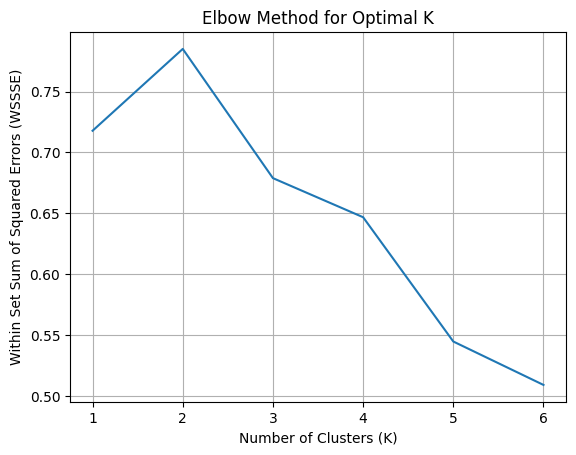

In [13]:
# Plotting WSSSE values
plt.plot(range(1, 7), wssse_values)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()

The graph for finding the optimal number of clusters using the
elbow method is as shown:


Next, we will plot all the data points along with cluster centers to
visualize the clusters:

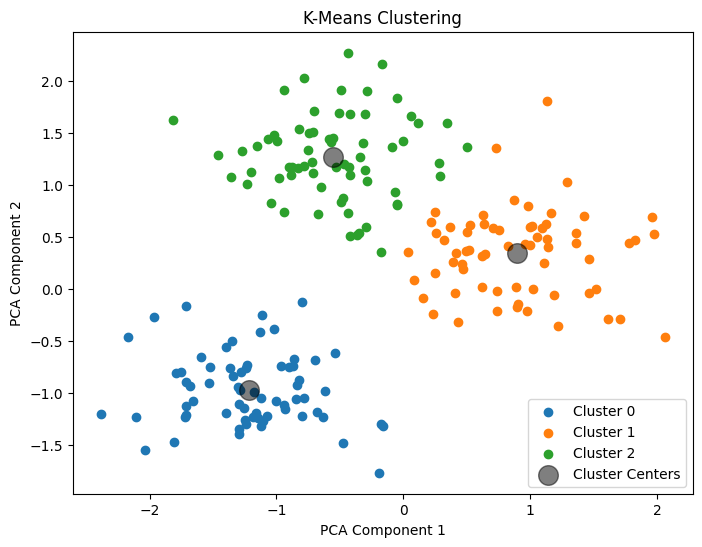

In [14]:
# Visualize the clusters
plt.figure(figsize=(8, 6))
for i in range(3):
    cluster_data = predictions.filter(predictions["cluster"] == i).select("scaled_features").collect()
    cluster_points = [point[0] for point in cluster_data]
    plt.scatter(*zip(*cluster_points), label=f"Cluster {i}")

plt.scatter(*zip(*model.clusterCenters()), c='black', s=200, alpha=0.5, label="Cluster Centers")
plt.title("K-Means Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()